# AIT Development notebook

## notebook of structure

| #  | Name                                               | cells | for_dev | edit               | description                                                                |
|----|----------------------------------------------------|-------|---------|--------------------|----------------------------------------------------------------------------|
| 1  | [Environment detection](##1-Environment-detection) | 1     | No      | uneditable         | detect whether the notebook are invoked for packaging or in production     |
| 2  | [Preparing AIT SDK](##2-Preparing-AIT-SDK)         | 1     | Yes     | uneditable         | download and install AIT SDK                                               |
| 3  | [Dependency Management](##3-Dependency-Management) | 3     | Yes     | required(cell #2)  | generate requirements.txt for Docker container                             |
| 4  | [Importing Libraries](##4-Importing-Libraries)     | 2     | Yes     | required(cell #1)  | import required libraries                                                  |
| 5  | [Manifest Generation](##5-Manifest-Generation)     | 1     | Yes     | required           | generate AIT Manifest                                                      |
| 6  | [Prepare for the Input](##6-Prepare-for-the-Input) | 1     | Yes     | required           | generate AIT Input JSON (inventory mapper)                                 |
| 7  | [Initialization](##7-Initialization)               | 1     | No      | uneditable         | initialization for AIT execution                                           |
| 8  | [Function definitions](##8-Function-definitions)   | N     | No      | required           | define functions invoked from Main area.<br> also define output functions. |
| 9  | [Main Algorithms](##9-Main-Algorithms)             | 1     | No      | required           | area for main algorithms of an AIT                                         |
| 10 | [Entry point](##10-Entry-point)                    | 1     | No      | uneditable         | an entry point where Qunomon invoke this AIT from here                     |
| 11 | [License](##11-License)                            | 1     | Yes     | required           | generate license information                                               |
| 12 | [Deployment](##12-Deployment)                      | 1     | Yes     | uneditable         | convert this notebook to the python file for packaging purpose             |

## notebook template revision history

1.0.1 2020/10/21

* add revision history
* separate `create requirements and pip install` editable and noeditable
* separate `import` editable and noeditable

1.0.0 2020/10/12

* new cerarion

## body

### #1 Environment detection

[uneditable]

In [ ]:
# Determine whether to start AIT or jupyter by startup argument
import sys
is_ait_launch = (len(sys.argv) == 2)

### #2 Preparing AIT SDK

[uneditable]

In [2]:
if not is_ait_launch:
    # get ait-sdk file name
    from pathlib import Path
    from glob import glob
    import re
    import os

    current_dir = %pwd

    ait_sdk_path = "./ait_sdk-*-py3-none-any.whl"
    ait_sdk_list = glob(ait_sdk_path)
    ait_sdk_name = os.path.basename(ait_sdk_list[-1])

    # install ait-sdk
    !pip install -q --upgrade pip
    !pip install -q --no-deps --force-reinstall ./$ait_sdk_name

### #3 Dependency Management

#### #3-1 [uneditable]

In [3]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_requirements_generator import AITRequirementsGenerator
    requirements_generator = AITRequirementsGenerator()

#### #3-2 [required]

In [4]:
if not is_ait_launch:
    requirements_generator.add_package('pytorch-fid', '0.3.0')
    requirements_generator.add_package('numpy', '1.24.4')
    requirements_generator.add_package('mmcv-full', '1.3.16')
    requirements_generator.add_package('mmgen', '0.6.0')
    requirements_generator.add_package('opencv-python', '4.10.0.84')
    requirements_generator.add_package('click', '8.1.7')
    requirements_generator.add_package('prettytable', '3.11.0')
    requirements_generator.add_package('mmcls', '0.18.0')

#### #3-3 [uneditable]

In [5]:
if not is_ait_launch:
    requirements_generator.add_package(f'./{ait_sdk_name}')
    requirements_path = requirements_generator.create_requirements(current_dir)

    !pip install -q -r $requirements_path 

### #4 Importing Libraries

#### #4-1 [required]

In [6]:
import torch
from torchvision import transforms
from pytorch_fid import fid_score
import numpy as np
import os
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import zipfile

#### #4-2 [uneditable]

In [7]:
# must use modules
from os import path
import shutil  # do not remove
from ait_sdk.common.files.ait_input import AITInput  # do not remove
from ait_sdk.common.files.ait_output import AITOutput  # do not remove
from ait_sdk.common.files.ait_manifest import AITManifest  # do not remove
from ait_sdk.develop.ait_path_helper import AITPathHelper  # do not remove
from ait_sdk.utils.logging import get_logger, log, get_log_path  # do not remove
from ait_sdk.develop.annotation import measures, resources, downloads, ait_main  # do not remove
# must use modules

### #5 Manifest Generation

[required]

In [8]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_manifest_generator import AITManifestGenerator
    manifest_genenerator = AITManifestGenerator(current_dir)
    manifest_genenerator.set_ait_name('eval_image_quality_by_pytorch_fid')
    manifest_genenerator.set_ait_description('PyTorchベースの画像生成モデル（対応可能なモデルはreferencesを参照）の品質を評価するため、Fréchet Inception Distance (FID)を計算することで、生成された画像の品質を数値化し、実際の画像データセットとの類似性を評価する')
    manifest_genenerator.set_ait_source_repository('https://github.com/aistairc/Qunomon_AIT_eval_image_quality_by_pytorch_fid')
    manifest_genenerator.set_ait_version('1.0')
    manifest_genenerator.add_ait_licenses('Apache License Version 2.0')
    manifest_genenerator.add_ait_keywords('pytorch-fid')
    manifest_genenerator.add_ait_keywords('image change')
    manifest_genenerator.set_ait_quality('https://ait-hub.pj.aist.go.jp/ait-hub/api/0.0.1/qualityDimensions/機械学習品質マネジメントガイドライン第三版/C-1機械学習モデルの正確性')

    #モデルとデータセットを設定 
    inventory_requirement_images = manifest_genenerator.format_ait_inventory_requirement(format_=['DIR'])
    manifest_genenerator.add_ait_inventories(name='benchmark_image_dir', 
                                             type_='dataset', 
                                             description='入力対象データセットのディレクトリ (すべて画像ファイルを一つフォルダに配置してください) ※イメージファイル形式については、JPEG/JPG、PNG、GIF、BMP、TIFFの画像形式をサポートしています。', 
                                             requirement=inventory_requirement_images)
    inventory_model = manifest_genenerator.format_ait_inventory_requirement(format_=['pt','pth'])
    manifest_genenerator.add_ait_inventories(name='pytorch_model', 
                                             type_='model', 
                                             description='pytorchでトレーニング済みGANs画像生成モデルのみサポートされている。\n (モデルのアーキテクチャをつけて保存が必要 例:torch.save(model, モデル名称))', 
                                             requirement=inventory_model)
    
    # パラメータ
    manifest_genenerator.add_ait_parameters(name='target_domain',
                                            type_='str',
                                            description='モデルで画像生成する時、渡すパラメータ（モデルによって、値が変わります。詳細はreferencesを参照）',
                                            default_val='winter')
    
    # references
    manifest_genenerator.add_ait_references(bib_info='MMGeneration is a powerful toolkit for generative models, especially for GANs now. It is based on PyTorch and MMCV. The master branch works with PyTorch 1.5+.',
                                            url='https://github.com/open-mmlab/mmgeneration/blob/master/configs/cyclegan/README.md')
    manifest_genenerator.add_ait_references(bib_info='MMGeneration is a powerful toolkit for generative models, especially for GANs now. It is based on PyTorch and MMCV. The master branch works with PyTorch 1.5+.',
                                            url='https://github.com/open-mmlab/mmgeneration/blob/master/configs/pix2pix/README.md')
    manifest_genenerator.add_ait_references(bib_info='GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium',
                                            url='https://arxiv.org/abs/1706.08500')
    
    # レポート
    manifest_genenerator.add_ait_measures(name='FID_Score',
                                          type_='float',
                                          structure='single',
                                          min='0',
                                          description='計算されたFIDスコア \n ※モデルの品質評価の観点からの基準:\n FID ≈ 0: 理想的なモデルの状態。生成画像が実際の画像とほぼ見分けがつかないレベル。\n FID < 10: 非常に高品質なモデル。生成画像が実際の画像と非常に近い。\n FID < 30: 実用的な品質のモデル。生成画像は実際の画像と多少異なるが、十分な品質を持つ。\n FID > 100: モデルの品質が低く、生成画像が実際の画像と大きく異なる。改善が必要。')

    manifest_genenerator.add_ait_resources(name='generated_images_resources',
                                           type_='picture',
                                           description='生成された画像のサンプル ※３枚まで表示')

    # ダウンロード
    manifest_genenerator.add_ait_downloads(name='generated_images',
                                           description='生成された画像のZIPファイル')

    manifest_genenerator.add_ait_downloads(name='Log',
                                           description='AIT実行ログ')
    
    manifest_path = manifest_genenerator.write()

### #6 Prepare for the Input

[required]

In [9]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_input_generator import AITInputGenerator
    input_generator = AITInputGenerator(manifest_path)
    input_generator.add_ait_inventories(name='benchmark_image_dir', value='benchmark_image_dir')
    input_generator.add_ait_inventories(name='pytorch_model', value='pytorch_model/cyclegansummer2winter.pth')
    input_generator.set_ait_params(name='target_domain', value='winter')
    input_generator.write()

### #7 Initialization

[uneditable]

In [10]:
logger = get_logger()

ait_manifest = AITManifest()
ait_input = AITInput(ait_manifest)
ait_output = AITOutput(ait_manifest)

if is_ait_launch:
    # launch from AIT
    current_dir = path.dirname(path.abspath(__file__))
    path_helper = AITPathHelper(argv=sys.argv, ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)
else:
    # launch from jupyter notebook
    # ait.input.json make in input_dir
    input_dir = '/usr/local/qai/mnt/ip/job_args/1/1'
    current_dir = %pwd
    path_helper = AITPathHelper(argv=['', input_dir], ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)

ait_input.read_json(path_helper.get_input_file_path())
ait_manifest.read_json(path_helper.get_manifest_file_path())

### do not edit cell

### #8 Function definitions

[required]

In [11]:
@log(logger)
def generate_images(model, image_dir, device, target_domain):
    # 指定されたパスから画像ファイルを取得
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]
    # 画像数をカウント
    num_images = len(image_files)
    # 生成した画像を保存するためのリスト
    generated_images = []
    # 画像の前処理を定義（リサイズ、Tensor変換、正規化）
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 画像サイズを調整（ここでは256x256）
        transforms.ToTensor(),          # 画像をTensorに変換
        transforms.Normalize([0.5], [0.5], [0.5])  # 画像のピクセル値を[-1, 1]に正規化
    ])
    # すべての画像を処理
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        # 画像を読み込み
        image = Image.open(img_path).convert('RGB')
        # 前処理を適用してTensorに変換
        tensor_image = transform(image).unsqueeze(0).to(device)
        # モデルで新しい画像を生成
        with torch.no_grad():
            results = model(img=tensor_image, test_mode=True, target_domain=target_domain)
            output = results['target']
        # 生成された画像を保存
        generated_images.append(output.cpu())

    return generated_images
        
def save_generated_images(images, generated_images_path):
    # 保存先ディレクトリ存在しない場合を作成
    os.makedirs(generated_images_path, exist_ok=True)
    for i, img in enumerate(images):
        if img.dim() == 2:  # 2次元の場合
            img = img.unsqueeze(0)  # バッチ次元を追加
        elif img.dim() == 3:  # 3次元の場合（C, H, W）
            img = img.unsqueeze(0)  # バッチ次元を追加
        
        # 画像を保存
        img = (img + 1) / 2
        save_image(img, os.path.join(generated_images_path, f'generated_image_{i}.png'))

In [12]:
@log(logger)
# FID計算
def calculate_fid(real_images_path, generated_images_path, device):
    # 計算FID
    fid_value = fid_score.calculate_fid_given_paths(
        [real_images_path, generated_images_path],
        batch_size=1,
        device=device,
        dims=2048
    )
    
    return fid_value

In [13]:
@log(logger)
def get_generated_images():
    directory="generated_images"
    if not os.path.exists(directory):
        raise FileNotFoundError(f"directory is not exist: {directory}")
    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp")
    image_files = [
        os.path.join(directory, file)
        for file in os.listdir(directory)
        if file.lower().endswith(valid_extensions)
    ]
    # 最低一枚
    if len(image_files) < 1:
        raise ValueError(f"{directory} file is not exist!")
    # 三枚まで
    image_files = image_files[:3]
    fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
    if len(image_files) == 1:
        axes = [axes]
    for i, file_path in enumerate(image_files):
        img = Image.open(file_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image {i + 1}')
    plt.tight_layout()
    plt.show()
    return image_files

In [14]:
@log(logger)
@measures(ait_output, 'FID_Score')
def add_measures(fid_score) -> float:
    return fid_score

In [15]:
@log(logger)
@resources(ait_output, path_helper, 'generated_images_resources')
def save_generated_images_resources(file_path: str = None, selected_image: str = None) -> str:
    save_images_path = file_path
    image_name = os.path.basename(selected_image)
    if not selected_image:
        raise ValueError("No image selected for saving!")
    # resourcesに画像を保存する
    shutil.copy(selected_image, save_images_path)
    return save_images_path + image_name

In [16]:
@log(logger)
@downloads(ait_output, path_helper, 'generated_images', 'generated_images.zip')
def save_generated_images_zip(file_path: str=None) -> None:
    zip_file_path = file_path
    images_directory = "generated_images"
    if not os.path.exists(images_directory):
        raise FileNotFoundError(f"directory is not exist: {images_directory}")
    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp")
    image_files = [
        os.path.join(images_directory, file)
        for file in os.listdir(images_directory)
        if file.lower().endswith(valid_extensions)
    ]
    if len(image_files) == 0:
        raise ValueError(f"{images_directory} file is not exist!")
    with zipfile.ZipFile(zip_file_path, "w", zipfile.ZIP_DEFLATED) as zipf:
        for image_file in image_files:
            arcname = os.path.relpath(image_file, images_directory)
            zipf.write(image_file, arcname=arcname)

In [17]:
@log(logger)
@downloads(ait_output, path_helper, 'Log', 'ait.log')
def move_log(file_path: str=None) -> str:
    shutil.move(get_log_path(), file_path)

### #9 Main Algorithms

[required]

In [18]:
@log(logger)
@ait_main(ait_output, path_helper, is_ait_launch)
def main() -> None:
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # パラメータ
    target_domain = ait_input.get_method_param_value('target_domain')
    # 画像パス
    real_images_path = ait_input.get_inventory_path('benchmark_image_dir')
    # 画像生成モデルパス
    model_path = ait_input.get_inventory_path('pytorch_model')
    # モデルロード  
    model = torch.load(model_path, map_location=device)
    model.eval()
    # 用意したモデルで画像を生成する
    generated_images = generate_images(model, real_images_path, device, target_domain)
    # 生成した画像を保存
    save_generated_images(generated_images, "generated_images")
    # FID計算
    fid_value = calculate_fid(real_images_path, "generated_images", device)
    # FID整形
    fid_value = str(round(fid_value, 8))
    # measure追加
    add_measures(fid_value)
    # resource追加
    image_files = get_generated_images()
    for img_file in image_files:
        save_generated_images_resources(file_path=None, selected_image=img_file)
    # 生成した画像を圧縮する
    save_generated_images_zip()
    # 結果表示
    print(f"FID_Score: {fid_value}")

### #10 Entry point

[uneditable]

100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


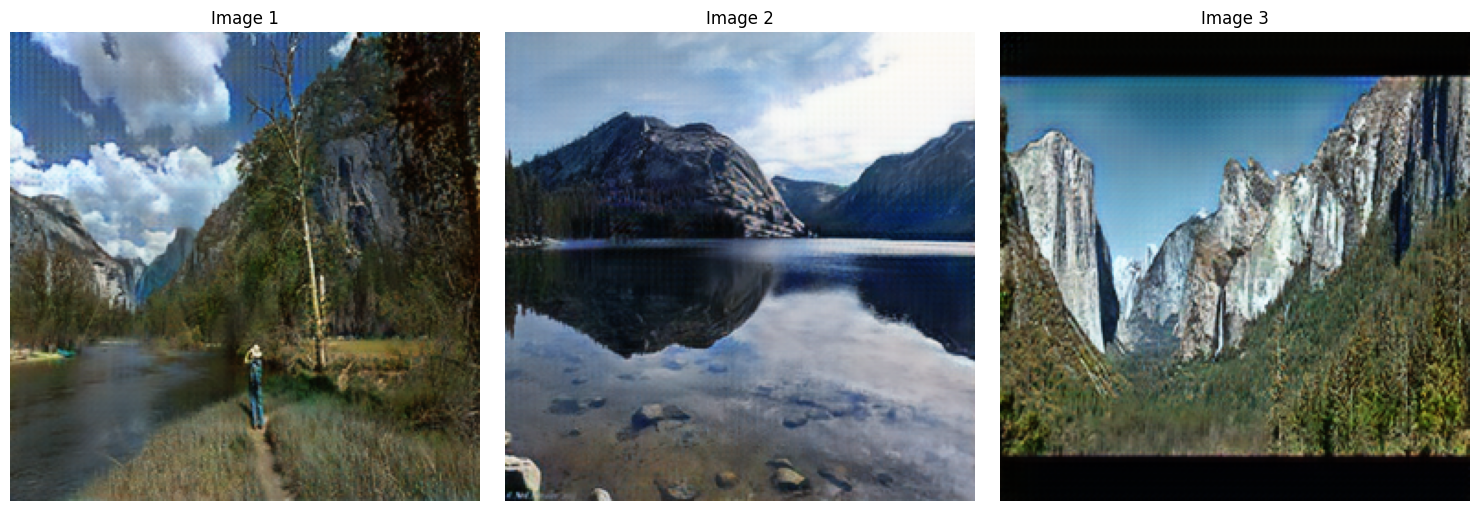

FID_Score: 92.32596704


In [19]:
if __name__ == '__main__':
    main()

### #11 License

[required]

In [20]:
## sample ##
ait_owner='AIST'
ait_creation_year='2024'

### #12 Deployment

[uneditable] 

In [21]:
if not is_ait_launch:
    from ait_sdk.deploy import prepare_deploy
    from ait_sdk.license.license_generator import LicenseGenerator
    
    current_dir = %pwd
    prepare_deploy(ait_sdk_name, current_dir, requirements_path)
    
    # output License.txt
    license_generator = LicenseGenerator()
    license_generator.write('../top_dir/LICENSE.txt', ait_creation_year, ait_owner)


/usr/local/lib/python3.9/site-packages/nbformat/json_compat.py:13: DeprecationWarning: Importing ErrorTree directly from the jsonschema package is deprecated and will become an ImportError. Import it from jsonschema.exceptions instead.
  from jsonschema import ErrorTree
/usr/local/lib/python3.9/site-packages/IPython/core/inputsplitter.py:21: DeprecationWarning: IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`
  warn('IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`',
